In [ ]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import prophet
from tsfresh.utilities.dataframe_functions import make_forecasting_frame
from tsfresh.utilities.dataframe_functions import roll_time_series
from tsfresh import extract_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import ComprehensiveFCParameters
from tqdm import tqdm
from datetime import datetime
from prophet import Prophet
from prophet.plot import plot_plotly
from typing import Any, Dict, Tuple
from datetime import timedelta
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing

warnings.filterwarnings('ignore')

import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

%matplotlib inline
warnings.filterwarnings('ignore')


ERROR:numba.cuda.cudadrv.driver:Call to cuInit results in CUDA_ERROR_NO_DEVICE


In [ ]:
!pip install tsfresh

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 97 kB 2.8 MB/s 
     |████████████████████████████████| 1.1 MB 36.5 MB/s 
     |████████████████████████████████| 9.8 MB 44.3 MB/s 
     |████████████████████████████████| 136 kB 37.4 MB/s 
     |████████████████████████████████| 1.3 MB 36.8 MB/s 
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.17.3
    Uninstalling protobuf-3.17.3:
      Successfully uninstalled protobuf-3.17.3
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.12.2
    Uninstalling statsmodels-0.12.2:
      Successfully uninstalled statsmodels-0.12.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-metadata 1.10.0 requires protobuf<4,>=3.13, but you have protobuf 3.11.2 which is incompa

Загружаем данные из txt примера. Можно подключиться в меню к диску, а соответственно к папке, либо заменить path к файлу

In [ ]:
path = '/content/drive/MyDrive/Project_1/test.txt'
data_prep = pd.read_csv(path, sep=",", header=None)
data_prep.columns = ['open_time','open', 'high', 'low', 'close', 'volume']
data_prep = data_prep.astype({'open': np.float64,'high': np.float64, 'low': np.float64, 'close': np.float64, 'volume': np.float64})
data_prep['normal_date'] = data_prep['open_time'].apply(lambda x: datetime.fromtimestamp(x))
data_prep = data_prep.reindex(columns=['normal_date','open', 'high', 'low', 'close', 'volume','open_time'])

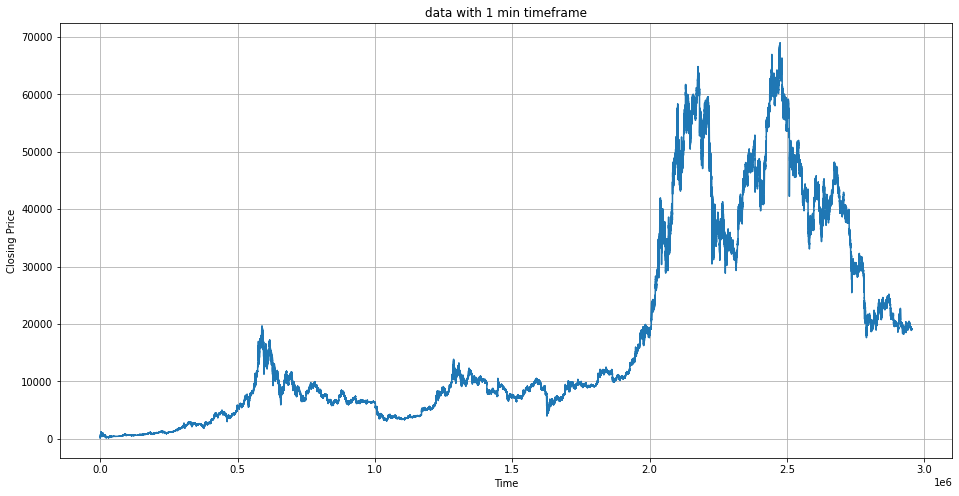

In [ ]:
data_prep['close'].plot(figsize=(16,8),title='data with 1 min timeframe',grid=True)
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.show()

Rolling window + fbprophet

В data.head() устанавливаем величину выборки

In [ ]:
data = pd.DataFrame(data_prep[['normal_date', 'close']])
data.columns = ["ds", "y"]
#data = data.head(2_000_000)

In [ ]:
print(data.shape)
data.head(5)
data.tail(5)

(2954383, 2)


,ds,y
2954378,2022-10-12 15:20:00,19119.9
2954379,2022-10-12 15:21:00,19118.0
2954380,2022-10-12 15:22:00,19120.0
2954381,2022-10-12 15:23:00,19119.1
2954382,2022-10-12 15:24:00,19119.0


In [ ]:
data.dropna(inplace = True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2954383 entries, 0 to 2954382
Data columns (total 2 columns):
 #   Column  Dtype         
---  ------  -----         
 0   ds      datetime64[ns]
 1   y       float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 67.6 MB


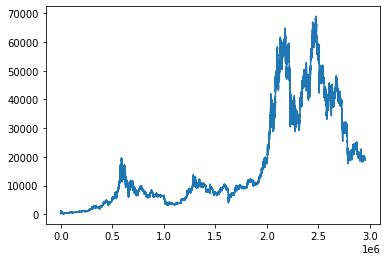

In [ ]:
plt.plot(data["y"])
plt.show()

Устанавливаем start_point. Точку после которой модель будет строить предсказание - middle_point, и end_point

In [ ]:
mode = 'prophet'
start_point = 2_000_000
middle_point = 2_000_500
end_point = 2_000_550
Time_start_end = data.iloc[start_point : end_point].index.values.copy()
Time_middle_end = data.iloc[middle_point : end_point].index.values.copy()
data_train = data.iloc[start_point : middle_point].copy()
data_test = data.iloc[middle_point : end_point].copy()
data = data.iloc[start_point : end_point]
y_test = data_test["y"].copy()
del data_test["y"]

print("data train shape: {0}, \ndata test shape: {1}, \ndata shape: {2}".format(data_train.shape, data_test.shape, data["y"].shape))

data train shape: (500, 2), 
data test shape: (50, 1), 
data shape: (550,)


In [ ]:
model = Prophet()
model.fit(data_train)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp698iyngj/plc6kj7_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp698iyngj/nahiq3og.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45287', 'data', 'file=/tmp/tmp698iyngj/plc6kj7_.json', 'init=/tmp/tmp698iyngj/nahiq3og.json', 'output', 'file=/tmp/tmp698iyngj/prophet_modelh1_pyeuw/prophet_model-20221031152324.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:23:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:23:24 - cmdstanpy - INFO - Chain 

In [ ]:
test_prediction = model.predict(data_test)
train_prediction = model.predict(pd.DataFrame(data_train["ds"]))

In [ ]:
def mean_absolute_percentage_error(y_test, test_pr): 
    return np.mean(np.abs((y_test - test_pr) / y_test)*100)

In [ ]:
def rmse(test_pr, y_test):
    return np.sqrt(mean_squared_error(test_pr, y_test))

In [ ]:
def smape(test_pr, y_test):
  mask = (abs(y_test) + abs(test_pr) != 0) & (~np.isnan(y_test)) & (~np.isnan(test_pr))
  y_test, test_pr = y_test, test_pr
  nominator = np.abs(y_test - test_pr)
  denominator = np.abs(y_test) + np.abs(test_pr)
  smape = np.mean((2.0 * nominator / denominator)[mask])
  return smape*100

In [ ]:
def mse_print(test_pr, y_test):
   mask = (~np.isnan(y_test)) & (~np.isnan(test_pr))
   mse = ((y_test - test_pr) ** 2)[mask]
   return mse

In [ ]:
def rmse_print(test_pr, y_test):
    return np.sqrt(mse_print(test_pr, y_test))

In [ ]:
def mae_print(y_test, test_pr): 
    return np.abs((y_test - test_pr) / y_test)

In [ ]:
def smae_print(test_pr, y_test):
  mask = (abs(y_test) + abs(test_pr) != 0) & (~np.isnan(y_test)) & (~np.isnan(test_pr))
  y_test, test_pr = y_test, test_pr
  nominator = np.abs(y_test - test_pr)
  denominator = np.abs(y_test) + np.abs(test_pr)
  element = ((2.0 * nominator / denominator)[mask])
  return element

In [ ]:
def normalize(array):
  normalized_arr = preprocessing.normalize([array])
  return [a for b in normalized_arr for a in b]

In [ ]:
def plot_results(time_series, Time, train_prediction, test_prediction, y_test, mode, description):
    
    """
    Plots the original time series and it prediction
    """
    if mode == 'prophet':
        ts = time_series["y"].values
        train_pr = train_prediction["yhat"].values
        test_pr = test_prediction["yhat"].values
        
    
    else:
        print("Check mode")
        return None
    
    plt.figure(figsize=(10,7))

    plt.plot(Time - start_point, ts, label = "true")
    plt.plot(Time - start_point, np.concatenate([train_pr, test_pr]), 
         label = "predictions, \n MAPE = {0} %, MAE = {1}, MSE = {2}, RMSE = {3}, SMAPE = {4} %".format(
             np.round(mean_absolute_percentage_error(test_pr, y_test), 3),
             np.round(mean_absolute_error(test_pr, y_test), 3), 
             np.round(mean_squared_error(test_pr, y_test), 3),
             np.round(rmse(test_pr, y_test), 3),
             np.round(smape(test_pr, y_test), 3)))


    plt.axvline(x=middle_point - start_point, label = "train-test-split", color = 'r')
    plt.xlabel("time", size = 20)
    plt.ylabel("value", size = 20)
    plt.title("{}".format(description), size = 20)


    plt.legend(fontsize = 15)

    plt.show()
    pass

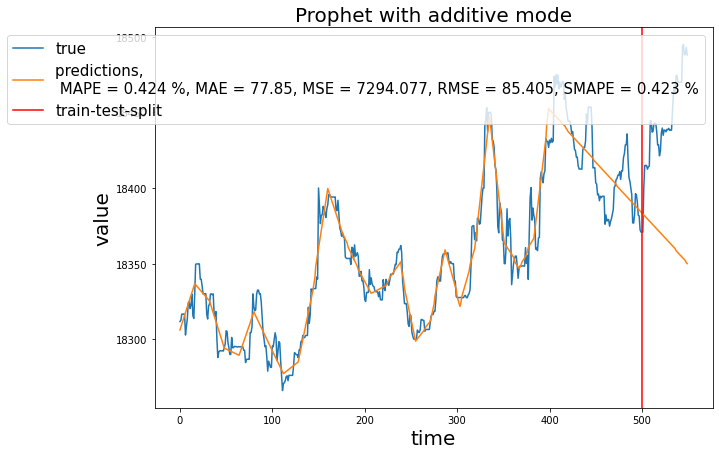

In [ ]:
description = "Prophet with additive mode"
plot_results(data, Time_start_end, train_prediction, test_prediction, y_test, mode, description)

Устанавливем набор статистических показателей

In [ ]:
dict_of_features = {'spkt_welch_density':[{'coeff': 1}], 'absolute_sum_of_changes':None, 'maximum': None,
                      'fft_coefficient':[{"coeff": 1, "attr": 'real'}], 'kurtosis':None, 
                       'agg_linear_trend':[{"attr": 'pvalue', "chunk_len": 1, "f_agg": 'mean'},
                                           {"attr": 'pvalue', "chunk_len": 1, "f_agg": 'max'}],
                      'number_peaks':[{'n':5}],'skewness': None,'count_below_mean':None }
settings = ComprehensiveFCParameters()

В значении max_timshift можно указать размер окна, который нам нужен

In [ ]:
def fit(model, data_train, dict_of_features, max_timeshift = 10, rolling_direction = 1 ):

    data_train_with_zero = data_train.append({"y": 0, "ds": data_train["ds"].iloc[-1]}, ignore_index=True)

    df_shift, y = make_forecasting_frame(data_train_with_zero["y"].values, kind = "price",
                        max_timeshift = 10, rolling_direction = 1)

    X_train = extract_features(df_shift, column_id="id", column_sort="time", 
                                    column_value="value", impute_function=impute, show_warnings=False,
                                    disable_progressbar = True,
                              default_fc_parameters = dict_of_features )

    X_train.dropna(axis = 1, inplace = True)
    
    X_train.dropna(axis = 1, inplace = True)
    data_train_with_zero["level_1"] = data_train_with_zero.index
    X_train = X_train.reset_index()
    X_train["level_1"] = X_train["level_1"] - 1
    final_train = pd.merge(data_train_with_zero[:-1], X_train, on = ["level_1", "level_1"])
    final_train = final_train.drop(columns = ['level_1', 'level_0'], axis = 1)
    
    # Add regressors
    for it in (set(final_train.columns) - set(['ds', 'y'])):
        model.add_regressor(it)
    
    # Fit the model
    model.fit(final_train)

    return final_train

In [ ]:
model = Prophet(seasonality_mode = 'additive')
final_train = fit(model, data_train, dict_of_features)

Rolling: 100%|██████████| 501/501 [00:02<00:00, 245.87it/s]
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp698iyngj/u5c39so5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp698iyngj/e8rn1fnk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4552', 'data', 'file=/tmp/tmp698iyngj/u5c39so5.json', 'init=/tmp/tmp698iyngj/e8rn1fnk.json', 'output', 'file=/tmp/tmp698iyngj/prophet_modela2o9yi5i/prophet_model-20221031152956.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:29:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chai

Здесь тоже стоит сменить max_timshift

In [ ]:
def predict(model, final_train, data_train, data_test):
        
    
    test_prict = model.predict(pd.DataFrame(final_train.iloc[-1][None, :], columns=final_train.columns))

    data_test_with_pred = data_train.append({
                            "y": test_prict["yhat"][0], "ds": data_test["ds"].iloc[0]}, ignore_index=True)

    for it in tqdm(range(1, data_test.shape[0])):

        df_shift, y = make_forecasting_frame(data_test_with_pred["y"].values, kind = "price",
                        max_timeshift = 10, rolling_direction = 1)

        X_test = extract_features(df_shift, column_id="id", column_sort="time", 
                                    column_value="value", impute_function=impute, show_warnings=False,
                                    disable_progressbar = True,
                                  default_fc_parameters = dict_of_features
                                 )

        X_test.dropna(axis = 1, inplace = True)

        X_test.dropna(axis = 1, inplace = True)
        data_test_with_pred["level_1"] = data_test_with_pred.index
        X_test = X_test.reset_index()
        X_test["level_1"] = X_test["level_1"] - 1
        final_test = pd.merge(data_test_with_pred[:-1], X_test, on = ["level_1", "level_1"])
        final_test = final_test.drop(columns = ['level_1', 'level_0'], axis = 1)

        test_pr = model.predict(pd.DataFrame(final_test.iloc[-1][None, :], columns=final_test.columns))

        data_test_with_pred = data_test_with_pred.append(
                                    {"y": test_pr["yhat"][0], "ds": data_test["ds"].iloc[it]}, ignore_index=True)

    return data_test_with_pred

In [ ]:
predictions = predict(model, final_train, data_train, data_test)

100%|██████████| 49/49 [03:20<00:00,  4.10s/it]


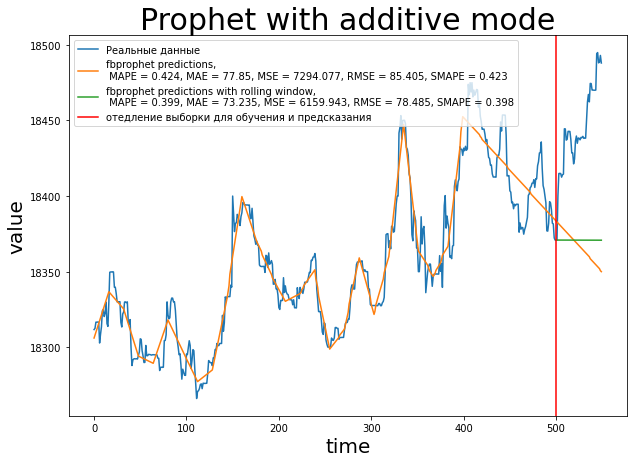

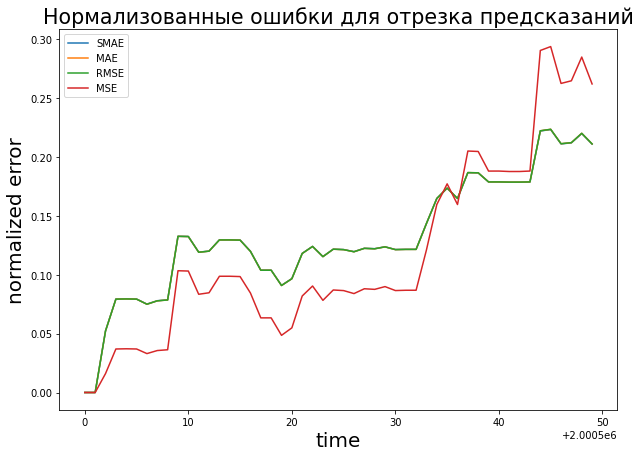

In [ ]:
ts = data["y"].values

train_pr = train_prediction["yhat"].values
test_pr = test_prediction["yhat"].values

rolling_predictions = predictions["y"].values

plt.figure(figsize=(10,7))

plt.plot(Time_start_end - start_point, ts, label = "Реальные данные")
#ax = plt.subplot()
#ax.bar(Time_middle_end, smape_print(rolling_predictions[(middle_point - start_point) :], y_test))
#plt.plot(Time_middle_end, smape_print(rolling_predictions[(middle_point - start_point) :], y_test), label = "SMAPE", color = 'red')

plt.plot(Time_start_end - start_point, np.concatenate([train_pr, test_pr]), 
         label = "fbprophet predictions, \n MAPE = {0}, MAE = {1}, MSE = {2}, RMSE = {3}, SMAPE = {4}".format(
             np.round(mean_absolute_percentage_error(test_pr, y_test), 3),
             np.round(mean_absolute_error(test_pr, y_test), 3), 
             np.round(mean_squared_error(test_pr, y_test), 3),
             np.round(rmse(test_pr, y_test), 3),
             np.round(smape(test_pr, y_test), 3)))

plt.plot(Time_middle_end - start_point, rolling_predictions[(middle_point - start_point) :], 
         label = "fbprophet predictions with rolling window, \n MAPE = {0}, MAE = {1}, MSE = {2}, RMSE = {3}, SMAPE = {4}".format(
             np.round(mean_absolute_percentage_error( rolling_predictions[(middle_point - start_point) :], y_test), 3),
             np.round(mean_absolute_error( rolling_predictions[(middle_point - start_point) :], y_test), 3), 
             np.round(mean_squared_error( rolling_predictions[(middle_point - start_point) :], y_test), 3),
             np.round(rmse( rolling_predictions[(middle_point - start_point) :], y_test), 3),
             np.round(smape( rolling_predictions[(middle_point - start_point) :], y_test), 3)))

plt.axvline(x=middle_point - start_point, label = "отедление выборки для обучения и предсказания", color = 'r')

plt.xlabel("time", size = 20)
plt.ylabel("value", size = 20)
plt.title("{}".format(description), size = 30)


plt.legend(fontsize = 10)

plt.show()
plt.figure(figsize=(10,7))
plt.plot(Time_middle_end, normalize(smae_print(rolling_predictions[(middle_point - start_point) :], y_test)), label = "SMAE")
plt.plot(Time_middle_end, normalize(mae_print(rolling_predictions[(middle_point - start_point) :], y_test)), label = "MAE")
plt.plot(Time_middle_end, normalize(rmse_print(rolling_predictions[(middle_point - start_point) :], y_test)), label = "RMSE")
plt.plot(Time_middle_end, normalize(mse_print(rolling_predictions[(middle_point - start_point) :], y_test)), label = "MSE")
plt.xlabel("time", size = 20)
plt.ylabel("normalized error", size = 20)
plt.title("Нормализованные ошибки для отрезка предсказаний", size = 20.65)
plt.legend(fontsize = 10)
plt.show()

In [ ]:
normalize(smae_print(rolling_predictions[(middle_point - start_point) :], y_test))

[0.010964875377877915,
 0.010964875377877915,
 0.12787099369020616,
 0.1941592745033991,
 0.35684100264751695,
 0.3935887909083188,
 0.4030594917056412,
 0.45564846390539326,
 0.4060900440903856,
 0.3584431477808511]

In [ ]:
normalize(rmse_print(rolling_predictions[(middle_point - start_point) :], y_test))

[0.010926386716704943,
 0.010926386716704943,
 0.1275776219228524,
 0.19382678578221468,
 0.35674029678151764,
 0.393605112723934,
 0.40310956513153534,
 0.4559163329962266,
 0.40615096494934105,
 0.358346342260878]

In [ ]:
normalize(mae_print(rolling_predictions[(middle_point - start_point) :], y_test))

[0.010926362791796975,
 0.010926362791796975,
 0.12757742049927,
 0.1938264901256598,
 0.3567399895976223,
 0.3936048158859082,
 0.40310955045572766,
 0.455916389527117,
 0.4061513285379581,
 0.3583467396931406]

In [ ]:
normalize(mse_print(rolling_predictions[(middle_point - start_point) :], y_test))

[0.00030305859607549786,
 0.00030305859607549786,
 0.04131640037626458,
 0.09536764538817413,
 0.3230559995116128,
 0.3932737273446838,
 0.4124959405872688,
 0.5276473653883799,
 0.41874385895977634,
 0.3259713446381622]